<a href="https://colab.research.google.com/github/GoldPapaya/info256-applied-nlp/blob/main/7.lm/HW7_BERT_Parts_of_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbamman/anlp25/blob/main/7.lm/HW7_BERT.ipynb)

# HW7: Part-of-speech tagging with BERT

In this homework, we will be using the contextual embeddings from a large masked language model (BERT) to do token classification with the Huggingface `transformers` library.

Part-of-speech (POS) tagging is a core task in NLP that involves identifying the part of speech for each token in a sentence. We will use the Universal Dependencies POS tags, as well as a manually annotated English UD corpus, to build a high-performing POS tagger.

To read more about the Universal Dependencies project, [see this website](https://universaldependencies.org/introduction.html). To read more about the universal POS tags that we will be relying on, [see this page](https://universaldependencies.org/u/pos/index.html).

In [1]:
from transformers import AutoTokenizer, BertModel
import torch
from torch import nn

In [2]:
# Make sure the GPU is available
torch.cuda.is_available()

True

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

## Familiarizing ourselves with POS

Download the datasets from the UD Github.

In [4]:
!wget https://github.com/UniversalDependencies/UD_English-EWT/raw/refs/heads/master/en_ewt-ud-train.conllu
!wget https://github.com/UniversalDependencies/UD_English-EWT/raw/refs/heads/master/en_ewt-ud-dev.conllu

--2025-10-10 17:23:38--  https://github.com/UniversalDependencies/UD_English-EWT/raw/refs/heads/master/en_ewt-ud-train.conllu
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/refs/heads/master/en_ewt-ud-train.conllu [following]
--2025-10-10 17:23:38--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/refs/heads/master/en_ewt-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14203025 (14M) [text/plain]
Saving to: ‘en_ewt-ud-train.conllu’

en_ewt-ud-train.con 100%[===================>]  13.54M  --.-KB/s    in 0.07s   

2025-10

In [5]:
# from https://universaldependencies.org/u/pos/index.html
idx2label = [
    "ADJ",
    "ADP",
    "ADV",
    "AUX",
    "CCONJ",
    "DET",
    "INTJ",
    "NOUN",
    "NUM",
    "PART",
    "PRON",
    "PROPN",
    "PUNCT",
    "SCONJ",
    "SYM",
    "VERB",
    "X",
]

label2idx = {
    lab: idx for idx, lab in enumerate(idx2label)
}

# the conllu files follow the format described here:
# https://universaldependencies.org/format.html
def parse_conllu(file, n=100):
    # read up to n sentences from the provided file
    dataset = []
    this_sentence = []
    this_labels = []
    for line in open(file, "r"):
        if line[0] == "#":
            continue
        line = line.strip()
        if len(line) == 0:
            dataset.append({
                "tokens": this_sentence,
                "upos": this_labels
            })
            this_sentence = []
            this_labels = []

            if len(dataset) >= n:
                return dataset

            continue
        idx, word, _, upos, _, _, _, _, _, _ = line.split("\t")
        if "-" in idx:
            # skip multiword tokens because each individual one is also included
            continue
        if upos not in label2idx:
            print(line)
        this_sentence.append(word)
        this_labels.append(label2idx[upos])

    return dataset

In [6]:
train_dataset = parse_conllu("en_ewt-ud-train.conllu", n=20_000)
dev_dataset = parse_conllu("en_ewt-ud-dev.conllu", n=5_000)

### Question 1

Take a look through the dataset to get a feel for this task. Then, manually annotate the following sentence:

```
Emily took a flight to Paris.
```

_Fill me in:_

```
Emily  - PROPN
took   - VERB
a      - DET
flight - NOUN
to     - ADP
Paris  - PROPN
```

## Setting up data helpers

The annotations are provided at the word level, but BERT tokenizes into subword tokens, so we need to make sure the labels still align.

Because we usually process inputs in parallel batches for efficiency, we also define a `collate` function that prepares a batch of examples for training.

In [7]:
def tokenize(batch):
    # tokenize the words
    output = tokenizer(batch["tokens"], is_split_into_words=True)

    # labels are provided on the word level, but we might tokenize into subword tokens
    # we also inject special tokens (like [CLS] and [SEP])
    # to account for this, we give null (-100) labels to any subword token that isn't the
    # first token of the word.
    # we configure the CrossEntropyLoss to ignore the -100 value
    # (see `ignore_index` in https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
    all_new_labels = []
    for i, labels in enumerate(batch["upos"]):
        new_labels = []
        prev_id = None
        for word_id in output.word_ids(batch_index=i):
            if word_id is None or word_id == prev_id:
                new_labels.append(-100)
            else:
                new_labels.append(labels[word_id])
            prev_id = word_id
        all_new_labels.append(new_labels)

    output["labels"] = all_new_labels
    return output

In [8]:
from torch.nn.utils.rnn import pad_sequence

def collate(items):
    # Converts from a list of dicts to a dict of lists
    batch = {
        k: [item[k] for item in items] for k in items[0]
    }
    # Tokenizes and pads each batch
    outputs = tokenize(batch)
    outputs = {
        k: pad_sequence([torch.tensor(l) for l in v], batch_first=True, padding_value=(0 if k != "labels" else -100))
        for k, v in outputs.items()
    }
    return outputs

## Define model

Our model architecture is as follows:

1. We encode the tokens with our BERT model.
2. We then use a linear classification layer on the last layer of attention outputs for _each token_, giving us a classification for each token.

### Question 2

When working with neural networks, a useful debugging strategy is making sure the shapes of your tensors are correct.
**Fill in the correct values for the shape assertions.**

In [14]:
class POSBert(nn.Module):
    def __init__(self, bert_model, num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.hidden_size = bert_model.config.hidden_size

        self.bert_model = bert_model
        self.classification = nn.Linear(self.hidden_size, self.num_labels)

    def forward(self, batch):
        device = next(self.parameters()).device

        # batch["input_ids"] has shape (B, L) where B is the batch size and L is the padded length
        B, L = batch["input_ids"].shape

        model_output = self.bert_model(
            batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            token_type_ids=batch["token_type_ids"].to(device)
        )
        hidden = model_output.last_hidden_state
        assert hidden.shape == (B, L, self.hidden_size)

        logits = self.classification(hidden)
        assert logits.shape == (B, L, self.num_labels)
        return logits

## Train model

In [10]:
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

In [11]:
from sklearn.metrics import f1_score

In [12]:
batch_size = 64
learning_rate = 3e-5
num_epochs = 1

def filter_preds(predicted, target):
    f_predicted = []
    f_target = []
    for pred, tar in zip(predicted, target):
        if tar == -100:
            continue
        f_predicted.append(pred)
        f_target.append(tar)
    return np.array(f_predicted), np.array(f_target)


def train(model, loss_fn, optimizer, loader, num_epochs=1):
    model.train()
    step = 0
    for epoch in range(num_epochs):
        for batch in tqdm(loader, desc="train"):
            optimizer.zero_grad()

            output = model(batch)
            loss = loss_fn(output.flatten(0, 1), batch["labels"].flatten(0, 1).to("cuda"))

            loss.backward()
            optimizer.step()

            # We `yield` at the end of each step, allowing us to iterate
            # over the training steps in the `training_loop` function.
            # This is called a `generator` in Python

            # See this page to learn more about generators:
            # https://wiki.python.org/moin/Generators
            yield {"epoch": epoch, "step": step}

            step += 1

def validate(model, loader):
    with torch.no_grad():
        model.eval()
        predicted = []
        target = []
        for batch in tqdm(loader, desc="dev", disable=True):
            output = model(batch)
            predicted.append(output.flatten(0, 1).argmax(-1).cpu().numpy())
            target.append(batch["labels"].flatten(0, 1).numpy())

        predicted = np.concatenate(predicted)
        target = np.concatenate(target)

        predicted, target = filter_preds(predicted, target)

        accuracy = (predicted == target).sum() / len(predicted)
        f1 = f1_score(target, predicted, average="macro")
        return {"accuracy": accuracy, "f1": f1}


def training_loop(model, loss, optimizer, train_loader, val_loader):
    # Train loop
    dev_scores = []

    dev_scores.append(validate(model, val_loader))
    for i, step in enumerate(train(model, loss, optimizer, train_loader)):
        if i % 10 == 0:
            # Validation loop every 10 train steps
            dev_scores.append(validate(model, val_loader))

    return dev_scores

### Question 3:

Fill in the code to train the POS model with cross entropy loss and the Adam optimizer. Use the learning rate that we defined above.

We also use [Pytorch data loaders](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) to help batch our data efficiently. We want to shuffle batches on each epoch for the train set for more stable training, but keep the dev batches unshuffled for consistency in our evaluation.

The training might take a few minutes, but if it takes longer than 10 minutes, make sure that you have moved the model to the GPU before training!

The lab material from Tuesday might be a useful reference here.

In [15]:
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased")
pos_model = POSBert(bert_model, num_labels=len(idx2label)).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pos_model.parameters(), lr=3e-5)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)

scores = training_loop(pos_model, loss_fn, optimizer, train_loader, dev_loader)

train: 100%|██████████| 196/196 [04:31<00:00,  1.38s/it]


## Inspect output

We'll first plot the accuracy and F1 validation curves. You should have a performance with high 90s in accuracy, and high-80s or low-90s in F1.

<Axes: >

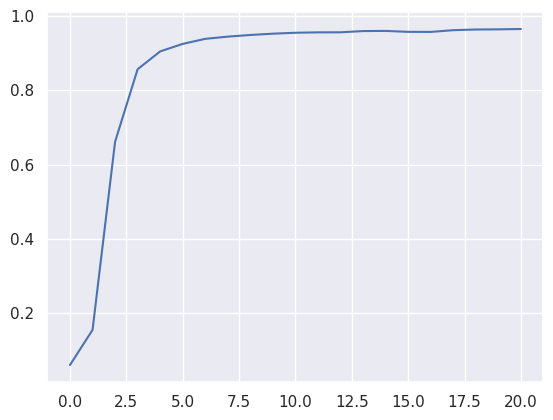

In [16]:
import seaborn as sns
sns.set()

sns.lineplot(x=list(range(len(scores))), y=[score["accuracy"] for score in scores])

<Axes: >

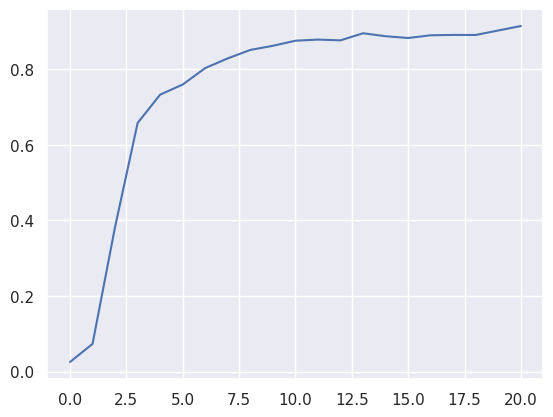

In [17]:
sns.lineplot(x=list(range(len(scores))), y=[score["f1"] for score in scores])

### Question 4

Use the `visualize_results` function to test the model on multiple sentences.

1. Find a sentence where the same word occurs twice with two different parts of speech.
2. Find a pair of sentences where the same token has different output labels.

Write a paragraph reflecting on why the architecture of BERT might be useful for POS tagging. Compare to some other methods we have learned in class, like static word embeddings or logistic regression on bags of words. What would be challenging about this task using those other methods? Why are contextual representations useful?

In [18]:
def visualize_results(sentence, model):
    tokens = tokenizer(sentence, return_tensors="pt")
    preds = model(tokens).argmax(-1)
    for tok, pred in zip(tokens.input_ids[0][1:-1], preds[0][1:-1]):
        print(tokenizer.decode(tok), idx2label[pred.item()])

In [19]:
visualize_results("Naitian is a PhD student at the UC Berkeley School of Information in California.", pos_model)

Na PROPN
##itia PROPN
##n PROPN
is AUX
a DET
PhD NOUN
student NOUN
at ADP
the DET
UC PROPN
Berkeley PROPN
School PROPN
of ADP
Information PROPN
in ADP
California PROPN
. PUNCT


In [25]:
visualize_results("'You should bank your earnings' he said, so I went to the bank", pos_model)

' PUNCT
You PRON
should AUX
bank VERB
your PRON
earning NOUN
##s NOUN
' PUNCT
he PRON
said VERB
, PUNCT
so ADV
I PRON
went VERB
to ADP
the DET
bank NOUN


In [23]:
visualize_results("You should bank your earnings", pos_model)

You PRON
should AUX
bank VERB
your PRON
earning NOUN
##s NOUN


In [24]:
visualize_results("I went to the bank", pos_model)

I PRON
went VERB
to ADP
the DET
bank NOUN


### Question 5

You may have noticed that we are using a pre-trained multilingual BERT model. Pick another language that has UD annotations from the [list on this page](https://universaldependencies.org/). Download the `conllu` file from the linked Github repository for that language and train a new model on POS tagging for that language.

Compare the performance between the English results from above and the language you chose. If you are familiar with the language, feel free to also inspect the model outputs on some of your own sentences.

If you find yourself running out of memory on the GPU, you may want to restart the kernel to clear the previous model before doing this last part.

In [33]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-train.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-dev.conllu

--2025-10-10 18:19:54--  https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23020440 (22M) [text/plain]
Saving to: ‘fr_gsd-ud-train.conllu.1’

fr_gsd-ud-train.con 100%[===================>]  21.95M  --.-KB/s    in 0.1s    

2025-10-10 18:19:55 (214 MB/s) - ‘fr_gsd-ud-train.conllu.1’ saved [23020440/23020440]

--2025-10-10 18:19:55--  https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request

In [35]:
with open("fr_gsd-ud-train.conllu", "r") as f:
    print(f.read()[:500])  # Print first 500 characters







<!DOCTYPE html>
<html
  lang="en"
  
  data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"
  data-a11y-animated-images="system" data-a11y-link-underlines="true"
  data-css-features="one_click_merge_conflict"
  >




  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link re


In [34]:
# Load French datasets (e.g., n=100 for quick testing; increase for full training)
fr_train_dataset = parse_conllu("fr_gsd-ud-train.conllu", n=1000)  # Use more for better training
fr_dev_dataset = parse_conllu("fr_gsd-ud-dev.conllu", n=200)

print(f"French train size: {len(fr_train_dataset)} sentences")
print(f"French dev size: {len(fr_dev_dataset)} sentences")

ValueError: not enough values to unpack (expected 10, got 1)